# import data & moduel

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
raw_df = pd.read_csv('Churn_Modelling.csv')
raw_df.shape # 10000 * 14

(10000, 14)

# 欄位介紹

| ColumnName | Description | Type |
| :--: | :--: | :--: |
| RowNumber | 資料編號 | 連續型資料 |
| CustomerId | 客戶ID | 連續型資料 |
| Surname | 客戶姓氏 | 字串資料 |
| Geography | 居住國家 | 離散型資料 |
| Gender | 性別 | 二元型資料 |
| Age | 年齡 | 連續型資料 |
| CreditScore | 信用分數 | 連續型資料 |
| Tenure | 往來期間 | 離散型資料 |
| Balance | 帳務餘額 | 連續型資料 |
| NumOfProducts | 持有產品數 | 離散型資料 |
| HasCrCard | 是否持卡 | 二元型資料 |
| IsActiveMember | 是否有效會員 | 二元型資料 |
| EstimatedSalary | 預估收入 | 連續型資料 |
| Exited | 是否流失 (0:未流失, 1:流失) | 二元型資料 |

# Check data infomation
---
* There is no missing values

In [4]:
raw_df.info() # 可以看到沒有缺失值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## 流失與否的數量分佈圖
---
* 約2成的人流失(2037)

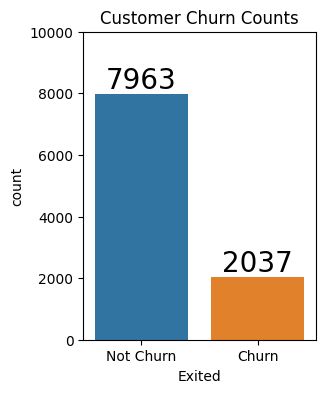

In [5]:
plt.figure(figsize=(3, 4))
ax = sns.countplot(data=raw_df, x='Exited')
plt.title('Customer Churn Counts')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=20)
plt.xticks(ticks = [0,1], labels=['Not Churn', 'Churn'])
plt.ylim(0, 10000)
plt.show()

In [6]:
# 性別欄位轉(0:female, 1:male)
df = raw_df.copy()
df['Gender'] = raw_df['Gender'].map({'Female':0, 'Male':1})
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,0,42,8,159660.80,3,1,0,113931.57,1


## 連續型資料分佈圖(CreditScore、Age、Balance、EstimatedSalary)
---
* CreditScore、Age 呈現常態分佈，在平均值有較高的流失數
* 40 ~ 50歲有較多的流失量(橘色)
* Balance 呈現雙峰分佈，在5萬以下及約12萬左右有較高的流失量
* EstimatedSalary 則是與流失率無太大關聯

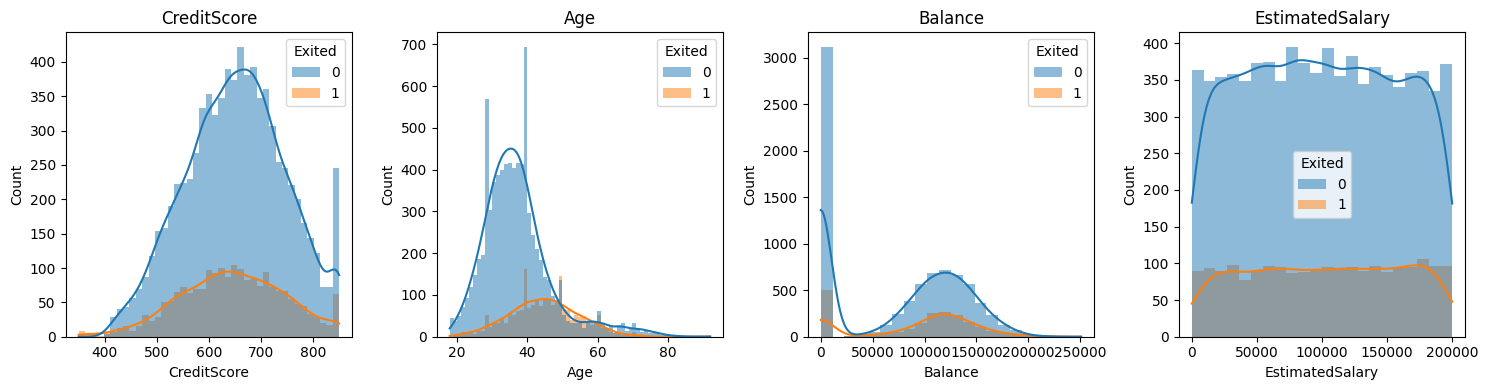

In [7]:
# 連續型資料做分布圖
features_col = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
ax = axes.flatten()
for idx, val in enumerate(features_col):
    sns.histplot(df, x = val, edgecolor = None, hue='Exited',kde=True, ax = ax[idx])
    ax[idx].set_title(val)
plt.tight_layout()
plt.show()

## 離散型資料分佈圖(Geography、Tenure、Gender、NumOfProducts、HasCrCard、IsActiveMember)
---
* 地區影響: 德國有較高的流失率
    * 法國 : ~ 16%
    * 德國 : ~ 32%
    * 西班牙 : ~ 17%
* Tenure與流失量無明顯關係(無論來往多久時間，幾乎有相同比例的人流失，約20%)
* 性別上女性流失比例約25%，男性約16%
* 持有產品數會很大地影響流失率, 由於持有3個以上的基數少，固有較大的流失率，選擇將2個以上是為一類:
    * 持有1個產品，流失比例約27%
    * 持有2個以上的產品，流失比例約15%
    * 而整體流失率為20.37%
* HasCrCard是否持卡不影響流失率，無倫有無約20%
* IsActiveMember會員會影響流失率，無會員約27%流失率；會員約14%

In [8]:
grouped = df.groupby(['Geography', 'Exited']).size().unstack()
grouped[1] / grouped.sum(axis=1)

Geography
France     0.161548
Germany    0.324432
Spain      0.166734
dtype: float64

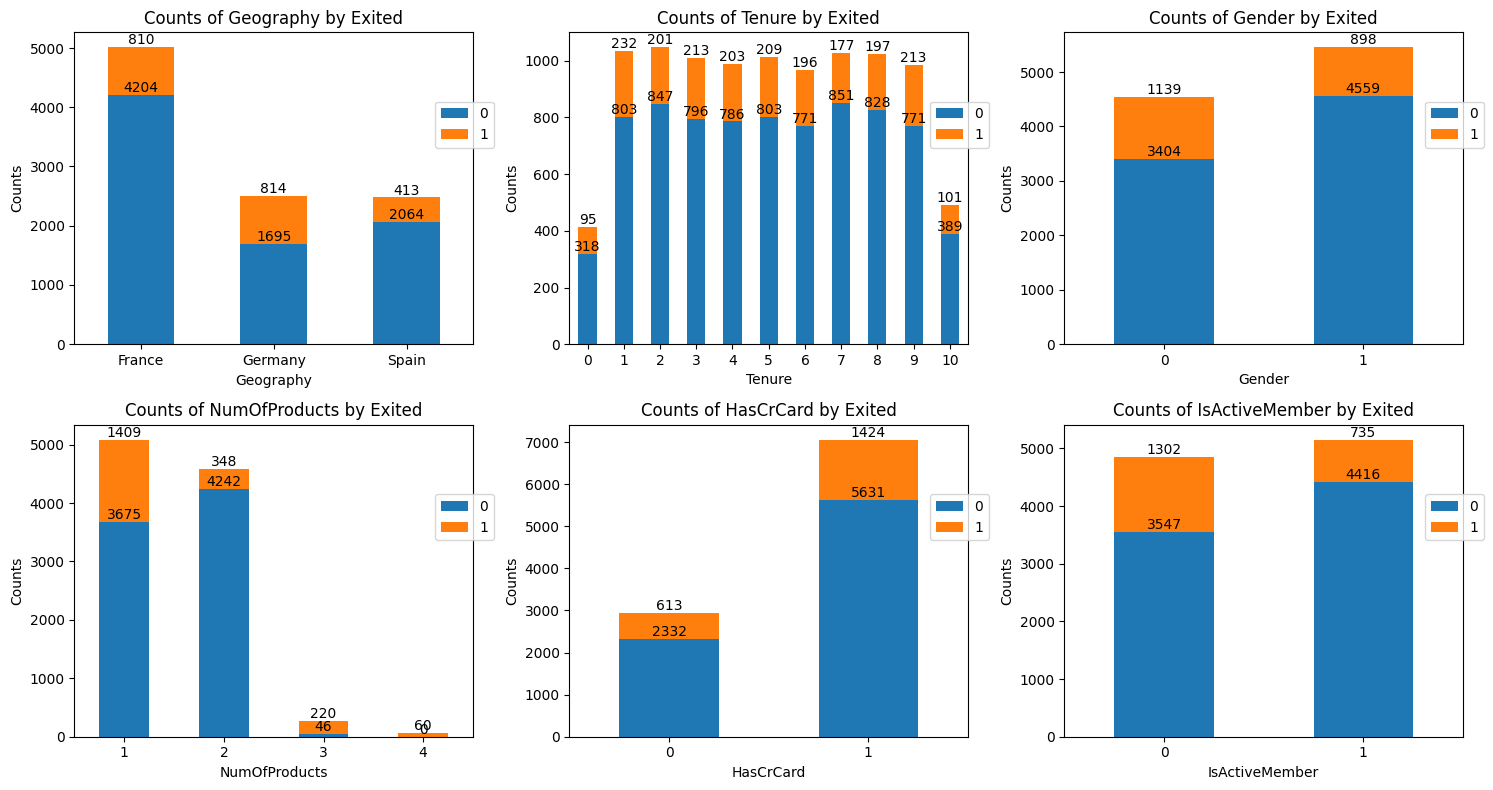

In [9]:
features_col = ['Geography', 'Tenure', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, feature in enumerate(features_col):
    counts = df.groupby([feature, 'Exited']).size().unstack()
    ax = counts.plot(kind='bar', stacked=True, ax=axes[i//3, i%3])

    ax.set_title(f'Counts of {feature} by Exited')
    ax.set_ylabel('Counts')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    # 在每個長條上顯示整數數字
    previous_heights = [0] * len(ax.patches)
    for p in ax.patches:
        height = p.get_height()
        x = p.get_x() + p.get_width() / 2.
        y = height + previous_heights[int(x)]
        ax.annotate(f'{int(height)}', (x, y), ha='center', va='top', xytext=(0, 10), textcoords='offset points')
        previous_heights[int(x)] += height

    ax.legend(loc='upper right', bbox_to_anchor=(1.07, 0.8))

plt.tight_layout()
plt.show()

## boxchart
---
年齡有較多離群值

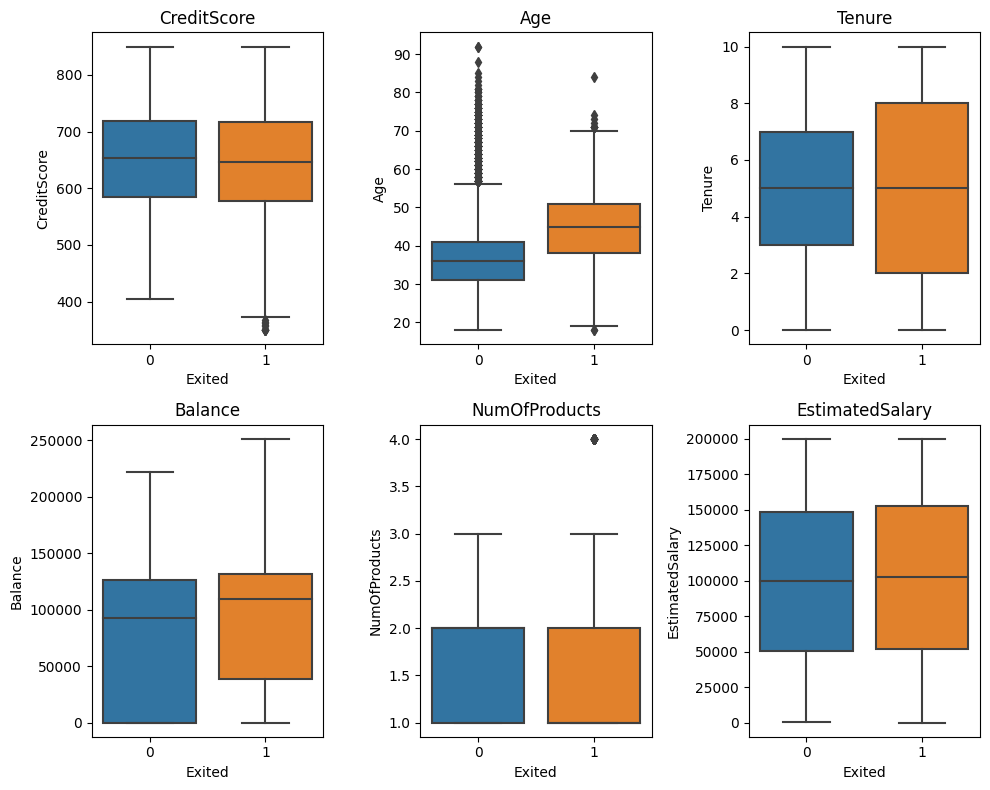

In [10]:
# 針對非二分法的特徵做box chart
features_col = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
ax = axes.flatten()
for idx, val in enumerate(features_col):
    sns.boxplot(data=df, x='Exited', y=val, ax=ax[idx])
    ax[idx].set_title(val)
plt.tight_layout()
plt.show()

# 特徵工程

In [11]:
# 保留會影響流失的特徵
importance_df = df[['Exited','CreditScore','Geography','Gender','Age','Balance','NumOfProducts','IsActiveMember']]

In [12]:
# 離散 : Tenure、NumOfProducts、Geography
# 二元 : Gender、HasCrCard、IsActiveMember、Exited
# 連續 : CreditScore、Age、Balance、EstimatedSalary
importance_df.head(3)

,Exited,CreditScore,Geography,Gender,Age,Balance,NumOfProducts,IsActiveMember
0,1,619,France,0,42,0.00,1,1
1,0,608,Spain,0,41,83807.86,1,1
2,1,502,France,0,42,159660.80,3,0


In [13]:
# NumOfProducts產品數因為3、4數量少，合併到2個，最後轉為二元分佈
importance_df['NumOfProducts'] = importance_df['NumOfProducts'].map(lambda x:1 if x > 2 else 0)

C:\Users\DAN\AppData\Local\Temp\ipykernel_22412\528351378.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  importance_df['NumOfProducts'] = importance_df['NumOfProducts'].map(lambda x:1 if x > 2 else 0)


In [14]:
# One-hot 離散資料
encoded_df = pd.get_dummies(importance_df, columns=['Geography'])
encoded_df

,Exited,CreditScore,Gender,Age,Balance,NumOfProducts,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain
0,1,619,0,42,0.00,0,1,True,False,False
1,0,608,0,41,83807.86,0,1,False,False,True
2,1,502,0,42,159660.80,1,0,True,False,False
3,0,699,0,39,0.00,0,0,True,False,False
4,0,850,0,43,125510.82,0,1,False,False,True
...,...,...,...,...,...,...,...,...,...,...
9995,0,771,1,39,0.00,0,0,True,False,False
9996,0,516,1,35,57369.61,0,1,True,False,False
9997,1,709,0,36,0.00,0,1,True,False,False
9998,1,772,1,42,75075.31,0,0,False,True,False


In [15]:
# 連續型資料標準化(只有CreditScore、Age為常態分佈)
# Balance為雙峰分佈故保留
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

# 這兩個常態分佈做z標準化
encoded_df[['CreditScore', 'Age']] = scaler.fit_transform(encoded_df[['CreditScore', 'Age']])

# Balance做最小-最大標準化
encoded_df['Balance'] = min_max_scaler.fit_transform(encoded_df['Balance'].values.reshape(-1, 1))

In [16]:
encoded_df

,Exited,CreditScore,Gender,Age,Balance,NumOfProducts,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain
0,1,-0.326221,0,0.293517,0.000000,0,1,True,False,False
1,0,-0.440036,0,0.198164,0.334031,0,1,False,False,True
2,1,-1.536794,0,0.293517,0.636357,1,0,True,False,False
3,0,0.501521,0,0.007457,0.000000,0,0,True,False,False
4,0,2.063884,0,0.388871,0.500246,0,1,False,False,True
...,...,...,...,...,...,...,...,...,...,...
9995,0,1.246488,1,0.007457,0.000000,0,0,True,False,False
9996,0,-1.391939,1,-0.373958,0.228657,0,1,True,False,False
9997,1,0.604988,0,-0.278604,0.000000,0,1,True,False,False
9998,1,1.256835,1,0.293517,0.299226,0,0,False,True,False


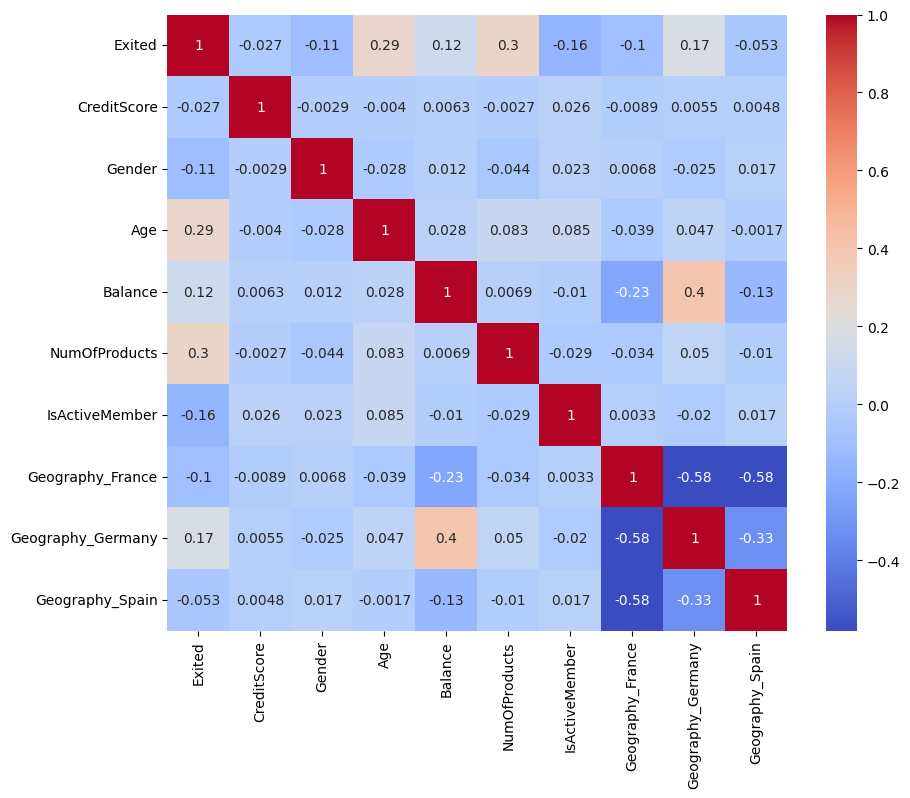

In [17]:
plt.figure(figsize = (10 , 8))
sns.heatmap(encoded_df.corr(), annot = True, cmap = 'coolwarm')
plt.show()

In [18]:
# NumOfProducts、Age、Geography_Germany、IsActiveMember為較重要影響流失的幾個因子
encoded_df.corr()['Exited'].abs().sort_values(ascending=False)

Exited               1.000000
NumOfProducts        0.298637
Age                  0.285323
Geography_Germany    0.173488
IsActiveMember       0.156128
Balance              0.118533
Gender               0.106512
Geography_France     0.104955
Geography_Spain      0.052667
CreditScore          0.027094
Name: Exited, dtype: float64

# 建模

In [19]:
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import numpy as np

In [20]:
data_df = encoded_df.copy()

In [21]:
X = data_df.drop('Exited', axis=1)
y = data_df['Exited']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)

In [ ]:
# 邏輯回歸（Logistic Regression）
LOGR = LogisticRegression(random_state = 0)
LOGR.fit(X_train, y_train)

# 支持向量機（Support Vector Machines）
SVMc = SVC(probability=True, random_state = 0)
SVMc.fit(X_train, y_train)

# 決策樹（Decision Trees）
DT = DecisionTreeClassifier(random_state = 0)
DT.fit(X_train, y_train)

# 梯度提升樹（Gradient Boosting Trees）
GBDT = GradientBoostingClassifier(random_state = 0)
GBDT.fit(X_train, y_train)

# XGBoosting
XGB = xgb.XGBClassifier(random_state=0)
XGB.fit(X_train, y_train)

# 隨機森林（Random Forest）
RFC = RandomForestClassifier(random_state = 0)
RFC.fit(X_train, y_train)

# K最近鄰居（K-Nearest Neighbors）
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)

# 貝葉斯分類器（Naive Bayes Classifier）
NBC = GaussianNB()
NBC.fit(X_train, y_train)

## 選擇AUC交叉驗證、AUC正標籤預測(流失) 評估模型

In [24]:
def ROC_AUC_AverageScore(model, x, y):
    return cross_val_score(model,x ,y ,cv=5,scoring='roc_auc').mean()

def positive_auc_1(model, xtest, ytest):
    y_pred_proba = model.predict_proba(xtest)[:, 1]
    auc_roc = roc_auc_score(ytest, y_pred_proba)
    return auc_roc

def positive_auc(model, xtest, ytest):
    y_pred = model.predict(xtest)
    auc_roc = roc_auc_score(ytest, y_pred)
    return auc_roc

In [25]:
models = [LOGR, SVMc, DT, GBDT, XGB, RFC, KNN, NBC]
model_names = ['Logistic Regression', 'SVC', 'Decision Tree', 'Gradient Boosting Tree', 'XGB', 'Random Forest', 'KNN', 'NBC']
res = []
for model, name in zip(models, model_names):
    res.append({'Model': name,
                'AUC Average Score': ROC_AUC_AverageScore(model, X_train, y_train),
                'ROC_AUC_Score': positive_auc(model, X_test, y_test),
                'ROC_AUC_Score_1': positive_auc_1(model, X_test, y_test)})

In [26]:
result = pd.DataFrame(res)
result = result.sort_values('ROC_AUC_Score_1', ascending=False).reset_index(drop=True)
result

,Model,AUC Average Score,ROC_AUC_Score,ROC_AUC_Score_1
0,Gradient Boosting Tree,0.826762,0.704593,0.833426
1,Logistic Regression,0.792484,0.644177,0.811966
2,XGB,0.804581,0.695257,0.801698
3,NBC,0.776863,0.582373,0.792129
4,Random Forest,0.802822,0.705735,0.791129
5,SVC,0.758981,0.672915,0.782499
6,KNN,0.745890,0.679213,0.760071
7,Decision Tree,0.659379,0.657577,0.657364


### 各模型AUC繪圖

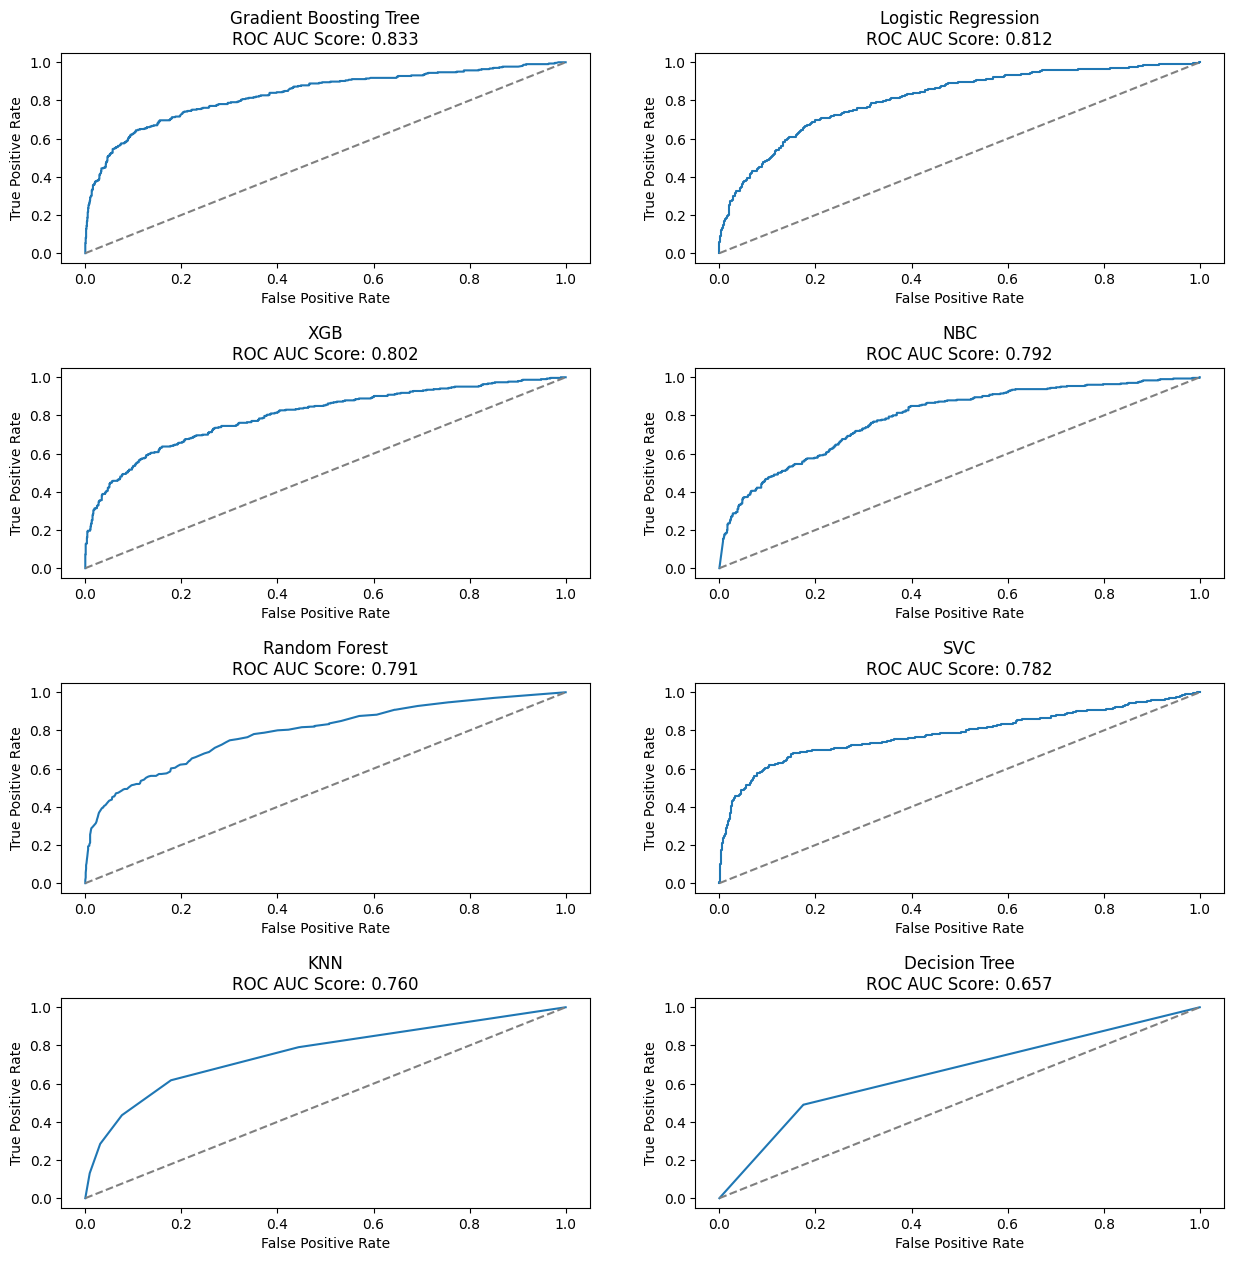

In [28]:
model_names = ['Logistic Regression', 'SVC', 'Decision Tree', 'Gradient Boosting Tree', 'XGB', 'Random Forest', 'KNN', 'NBC']
models = [LOGR, SVMc, DT, GBDT, XGB, RFC, KNN, NBC]
M = {k:v for k,v in zip(model_names, models)}

fig, axs = plt.subplots(4, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.5)

for i, row in enumerate(result.iterrows()):
    model_name = row[1]['Model']
    roc_auc_score = row[1]['ROC_AUC_Score_1']

    ax = axs[i // 2, i % 2]
    ax.set_title(f'{model_name}\nROC AUC Score: {roc_auc_score:.3f}')

    model = M.get(model_name)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
plt.show()

### 各模型report

In [29]:
# 使用測試集進行預測
for name, model in M.items():
    y_pred = model.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred))

Logistic Regression
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1194
           1       0.70      0.32      0.44       306

    accuracy                           0.83      1500
   macro avg       0.77      0.64      0.67      1500
weighted avg       0.82      0.83      0.81      1500

SVC
              precision    recall  f1-score   support

           0       0.86      0.98      0.91      1194
           1       0.80      0.37      0.51       306

    accuracy                           0.85      1500
   macro avg       0.83      0.67      0.71      1500
weighted avg       0.85      0.85      0.83      1500

Decision Tree
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1194
           1       0.42      0.49      0.45       306

    accuracy                           0.76      1500
   macro avg       0.64      0.66      0.65      1500
weighted avg       0.77      0.76   

## 模型優化
---
* 調整權重(流失量通常較少) 該資料集流失比例為1:5
* 超參數優化

In [30]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [ ]:
# LogisticRegression
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200],
    'class_weight':[None, {0: 1, 1: 5}]
}
logreg = LogisticRegression(random_state=0)
gscv_logr = GridSearchCV(logreg, param_grid, scoring='roc_auc', cv=5)
gscv_logr.fit(X_train, y_train)

In [32]:
print("Best Parameters: ", gscv_logr.best_params_)
print("Best ROC AUC Score: ", gscv_logr.best_score_)

y_pred_proba = gscv_logr.best_estimator_.predict_proba(X_test)[:, 1]
logr_auc = roc_auc_score(y_test, y_pred_proba)
logr_auc

Best Parameters:  {'C': 0.1, 'class_weight': {0: 1, 1: 5}, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best ROC AUC Score:  0.7956821662524275


0.8124911047612793

In [ ]:
# GradientBoostingClassifier
param_grid = {
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6]
}

gbdt = GradientBoostingClassifier(random_state=0)

gscv_gbdt = GridSearchCV(gbdt, param_grid, scoring='roc_auc', cv=5)
gscv_gbdt.fit(X_train, y_train)

In [34]:
print("Best Parameters: ", gscv_gbdt.best_params_)
print("Best ROC AUC Score: ", gscv_gbdt.best_score_)

gscv_gbdt.best_estimator_.fit(X_train, y_train)
y_pred_proba = gscv_gbdt.predict_proba(X_test)[:, 1]
gdbt_auc = roc_auc_score(y_test, y_pred_proba)
gdbt_auc

Best Parameters:  {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 6, 'n_estimators': 100}
Best ROC AUC Score:  0.827951969842134


0.8309603573422668

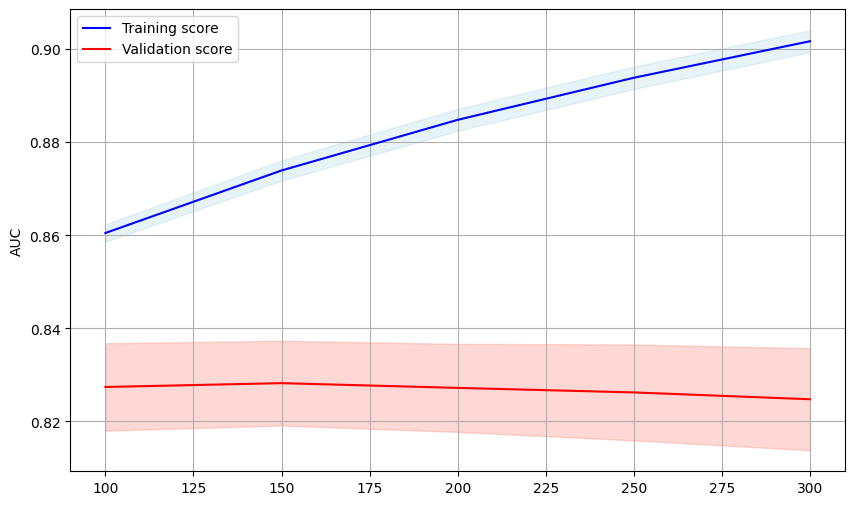

In [56]:
# 驗證曲線微調
# range = np.linspace(0.03, 0.05, 10)
range = np.arange(100,301,50)

gdbt = GradientBoostingClassifier(random_state=0,
                                  learning_rate=0.03,
                                  max_depth = 5,
                                  min_samples_split = 10)

train_scores, valid_scores = validation_curve(gdbt, X_train, y_train, param_name="n_estimators", param_range=range, cv=5, scoring="roc_auc")
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(range, train_mean, label="Training score", color="blue")
plt.plot(range, valid_mean, label="Validation score", color="red")
plt.fill_between(range, train_mean - train_std, train_mean + train_std, color="lightblue", alpha=0.3)
plt.fill_between(range, valid_mean - valid_std, valid_mean + valid_std, color="salmon", alpha=0.3)
plt.ylabel("AUC")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [60]:
gdbt_best = GradientBoostingClassifier(random_state=0,
                                       learning_rate=0.03,
                                       max_depth = 5,
                                       n_estimators = 100,
                                       min_samples_split = 10)
gdbt_best.fit(X_train, y_train)
y_pred_proba = gdbt_best.predict_proba(X_test)[:, 1]
gdbt_auc = roc_auc_score(y_test, y_pred_proba)
print(gdbt_auc)

0.8345211898271314


In [61]:
model_opt = {
    'Model':['LOGR_opt', 'LOGR', 'GDBT_opt', 'GDBT'],
    'ROC_AUC_Score_1' : [logr_auc, 0.811966, gdbt_auc, 0.833426]
}
new_result = pd.DataFrame(model_opt)
new_result

,Model,ROC_AUC_Score_1
0,LOGR_opt,0.812491
1,LOGR,0.811966
2,GDBT_opt,0.834521
3,GDBT,0.833426


In [62]:
y_pred = gscv_logr.best_estimator_.predict(X_test)
print('LOGR_opt')
print(classification_report(y_test, y_pred))

print('GDBT_opt')
y_pred = gdbt_best.predict(X_test)
print(classification_report(y_test, y_pred))

LOGR_opt
              precision    recall  f1-score   support

           0       0.93      0.66      0.77      1194
           1       0.38      0.80      0.51       306

    accuracy                           0.69      1500
   macro avg       0.65      0.73      0.64      1500
weighted avg       0.82      0.69      0.72      1500

GDBT_opt
              precision    recall  f1-score   support

           0       0.87      0.97      0.91      1194
           1       0.78      0.42      0.54       306

    accuracy                           0.86      1500
   macro avg       0.82      0.69      0.73      1500
weighted avg       0.85      0.86      0.84      1500

